In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

from ram.analysis.run_manager import RunManager
from ram.analysis.model_selection.combo_search import CombinationSearch
from ram.analysis.model_selection.pair_search import PairSearch
from ram.analysis.statistics import get_stats, rollup_returns

In [2]:
RunManager.get_run_names('StatArbStrategy')

,RunName,RunDate,Completed,Description
0,run_0068,2018-03-06,True,"Sector 20, version 002"
1,run_0069,2018-03-07,True,"Sector 20, version 2 rerun with univ filtering"
2,run_0070,2018-03-19,True,"Sector 20, post refactor run"
3,run_0071,2018-03-21,True,"Sector 20, 2001 start date, 16cpu comp"
4,run_0072,2018-03-21,True,"Sector 20, 2001 start date, 64cpu comp"
5,run_0078,2018-04-18,True,"Sector 20, new pricing data"
6,run_0079,2018-04-25,True,Rerun with data since 2004
7,run_0080,2018-04-26,False,Rerun of version 24 data
8,run_0081,2018-04-30,True,New hyperparams
9,run_0085,2018-05-01,True,"new params, longer params/hyperparms"


In [3]:
drop_params = [('model', "{u'type': u'reg'}"), ('per_side_count', 5), ('score_var', 'prma_20')]

run1 = RunManager('StatArbStrategy', 'run_0100', drop_params=drop_params, test_periods=0)

In [4]:
comb1 = CombinationSearch()
comb1.set_selection_criteria('sharpe')
comb1.params['training_epochs'] = 20

comb1.add_run(run1)
comb1.start()

Reading and aggregating runs...


  0%|          | 0/20 [00:00<?, ?it/s]

Finished aggregating runs...


100%|██████████| 20/20 [04:04<00:00, 12.25s/it]


# Day Of Month

In [51]:
# Enumerate the days of the month
data = comb1.best_results_returns.copy()
dates = data.index
indexes = []
month = dates[0].month

ind = 0
for d in dates:
    if d.month != month:
        ind = 0
        month = d.month
    indexes.append(ind)
    ind += 1

data['time_index'] = indexes

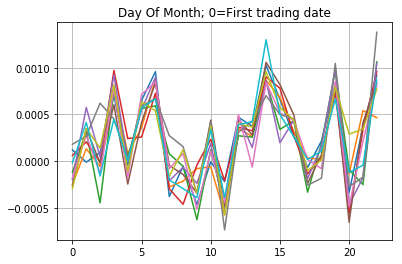

In [52]:
plt.figure()
plt.plot(data.dropna().groupby('time_index').median())
plt.grid()
plt.title('Day Of Month; 0=First trading date')
plt.show()

In [31]:
counts = data.time_index.value_counts().reset_index()
counts.columns = ['DayOfMonth', 'Count']
counts = counts.sort_values('DayOfMonth').reset_index(drop=True)

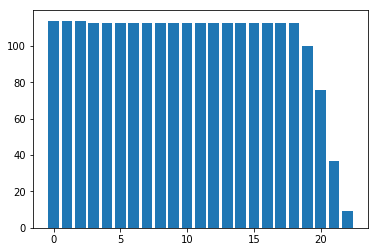

In [32]:
plt.figure()
plt.bar(counts.DayOfMonth, counts.Count)
plt.show()

# Day Of Week

In [45]:
data = comb1.best_results_returns.copy()
data['DayOfWeek'] = [x.weekday() for x in data.index]

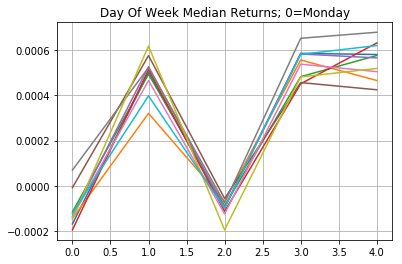

In [50]:
plt.figure()
plt.plot(data.dropna().groupby('DayOfWeek').median())
plt.grid()
plt.title('Day Of Week Median Returns; 0=Monday')
plt.show()

# Month

In [53]:
data = comb1.best_results_returns.copy()
data['Month'] = [x.month for x in data.index]

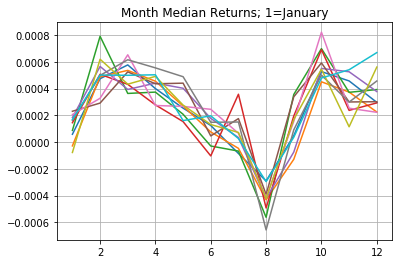

In [55]:
plt.figure()
plt.plot(data.dropna().groupby('Month').median())
plt.grid()
plt.title('Month Median Returns; 1=January')
plt.show()

In [64]:
# Drop August
data1 = comb1.best_results_returns.copy().dropna()
data2 = comb1.best_results_returns.copy().dropna()

months_filter = [x.month == 8 for x in data2.index]
data2.loc[months_filter] = 0

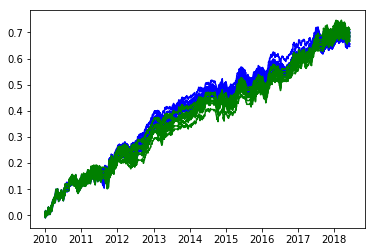

In [65]:
plt.figure()
plt.plot(data1.cumsum(), 'b')
plt.plot(data2.cumsum(), 'g')
plt.show()

In [69]:
get_stats(data1).mean(axis=1)

Total               0.67847
Mean                0.00030
Std                 0.00389
Skew                0.15030
Kurt                2.18000
Sharpe              1.30599
Sortino             2.32110
MinRet             -0.01905
WinP                0.53198
DD%                -0.06218
DDDays            148.10000
UnderwaterDays    169.40000
Underwater%        -0.05874
TimeAtHighs         0.13660
VaR_5perc          -0.00579
CVaR_5perc         -0.00823
LPM_2               0.00645
dtype: float64

In [70]:
get_stats(data2).mean(axis=1)

Total               0.68867
Mean                0.00030
Std                 0.00362
Skew                0.07227
Kurt                2.02000
Sharpe              1.41836
Sortino             2.47939
MinRet             -0.01721
WinP                0.49547
DD%                -0.05978
DDDays            109.80000
UnderwaterDays    151.10000
Underwater%        -0.05026
TimeAtHighs         0.13600
VaR_5perc          -0.00541
CVaR_5perc         -0.00783
LPM_2               0.00563
dtype: float64

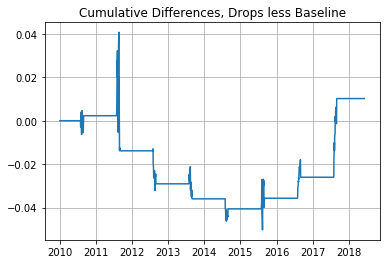

In [77]:
plt.figure()
plt.plot(data2.cumsum().mean(axis=1) - data1.cumsum().mean(axis=1))
plt.title('Cumulative Differences, Drops less Baseline')
plt.grid()
plt.show()

In [81]:
data = comb1.best_results_returns.copy()
months_flags = [x.month == 8 for x in data.index]
data['Year'] = [x.year for x in data.index]

data = data[months_flags]

data.groupby('Year').sum().mean(axis=1)

Year
2009         NaN
2010   -0.002302
2011    0.016154
2012    0.015200
2013    0.006922
2014    0.004623
2015   -0.004906
2016   -0.009665
2017   -0.036226
dtype: float64

# Year

In [56]:
data = comb1.best_results_returns.copy()
data['Year'] = [x.year for x in data.index]

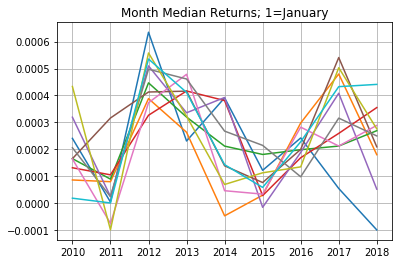

In [57]:
plt.figure()
plt.plot(data.dropna().groupby('Year').median())
plt.grid()
plt.title('Month Median Returns; 1=January')
plt.show()